# CPU time Comparison

In [9]:
import numpy as np
import cv2
import IPython
import pywt
from PIL import Image
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from time import time

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

In [10]:
photo = 'imagen.jpg'
array_photo = jpg_to_pgm(photo)
scale, width = 7, array_photo.shape[0]

### With Libraries

#### functions

In [11]:
def haar_wavelet_transform(image, scales):
    coeffs = []
    for i in range(scales):
        image, cD = pywt.dwt2(image, 'db4')
        coeffs.append(cD)
    coeffs.append(image)
    coeffs.reverse()
    return coeffs

#### One scale

The CPU time was 0.039998531341552734 seconds


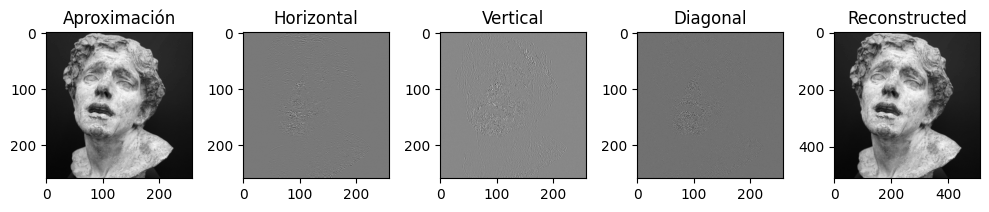

In [12]:
initial_time = time()
coeffs = pywt.dwt2(array_photo, 'db4')
cAL, (cHL, cVL, cDL) = coeffs
reconstructed_image = pywt.waverec2(coeffs, 'db4')
final_time = time()

print(f"The CPU time was {final_time - initial_time} seconds")
fig, axes = plt.subplots(1, 5, figsize=(10, 10))
axes[0].imshow(cAL, cmap='gray')
axes[0].set_title('Aproximación')
axes[1].imshow(cHL, cmap='gray')
axes[1].set_title('Horizontal')
axes[2].imshow(cVL, cmap='gray')
axes[2].set_title('Vertical')
axes[3].imshow(cDL, cmap='gray')
axes[3].set_title('Diagonal')
axes[4].imshow(reconstructed_image, cmap='gray')
axes[4].set_title('Reconstructed')
plt.tight_layout()
plt.show()

#### Multiple Scales

The CPU time was 0.03305363655090332 seconds


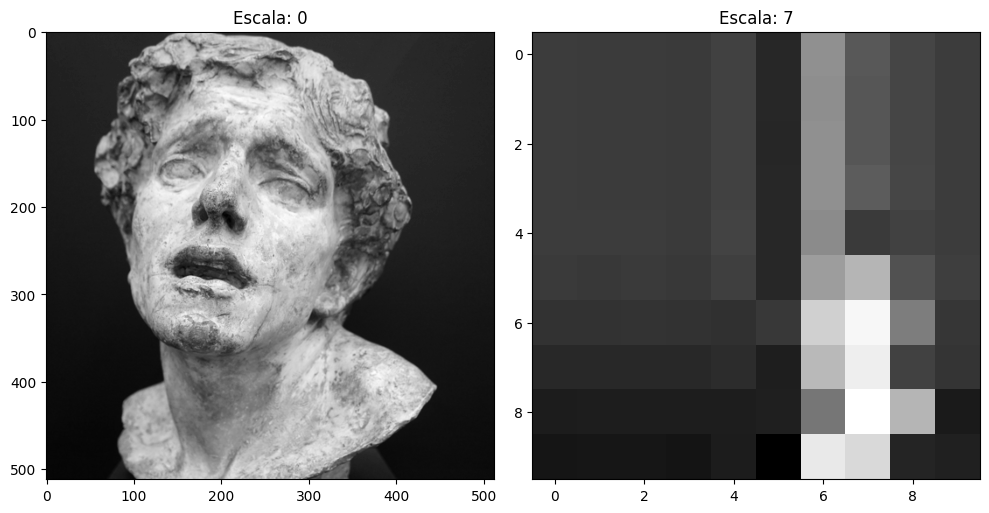

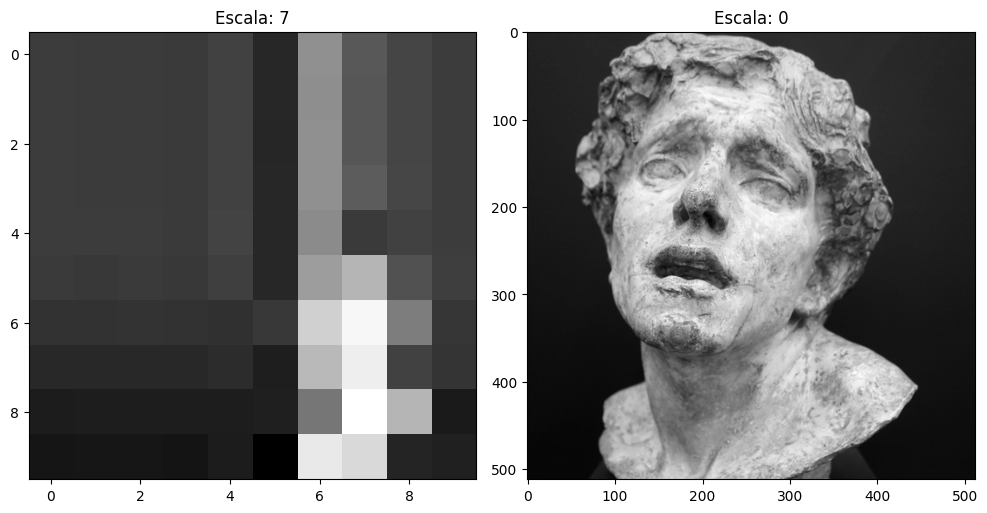

In [21]:
initial_time = time()
image_scaled = haar_wavelet_transform(array_photo, scale)
recosntructed_image = pywt.waverec2(image_scaled, 'db4')
final_time = time()

print(f"The CPU time was {final_time - initial_time} seconds")


fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(array_photo, cmap='gray')
axes[0].set_title('Escala: 0')
axes[1].imshow(image_scaled[0], cmap='gray')
axes[1].set_title(f'Escala: {scale}')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(image_scaled[0], cmap='gray')
axes[0].set_title(f'Escala: {scale}')
axes[1].imshow(recosntructed_image, cmap='gray')
axes[1].set_title('Escala: 0')
plt.tight_layout()
plt.show()

### Without Libraries

#### Functions


In [14]:
def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return csr_matrix(matrix_coeffs)
    # return csr_matrix(np.round(matrix_coeffs, 8))
     
     
root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])


def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(daubechies_coeffs.dot(row))
    result_V = daubechies_coeffs.dot(result_H)

    if scale == 1:
        normalized = result_V.copy()
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}")
    return np.ones_like(image), np.ones_like(image)


def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width):
    new_transform = transform_result.copy()
    image = []
    
    if scale == 1:
        daubechies_coeffs_transpose = daubechies_coeffs.T
        
        result_H = daubechies_coeffs_transpose.dot(transform_result)
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)
            
        return np.array(image)
    
    else: 
        tam_img = width // (2 ** scale) * 2
        aP = new_transform[:tam_img, :tam_img]
        daubechies_coeffs_transpose = np.transpose(function_daubechies_coeffs(aP))
        
        result_H = daubechies_coeffs_transpose.dot(aP)
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)

        new_transform[:len(image), :len(image)] = image

        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(new_transform),new_transform,scale-1,new_transform.shape[0])

def get_approx(image, scale):
    tam_img = image.shape[0] // (2 ** scale)
    return  image[:tam_img, :tam_img]

#### One scale

The CPU time was 0.43587779998779297 seconds


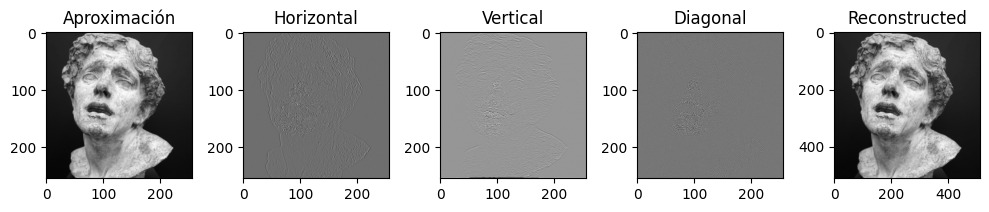

In [15]:
initial_time = time()
daubechies_4 = function_daubechies_coeffs(array_photo)
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,1,width)
cA, cH, cV, cD = split_matrix(normalized)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,1,width)
final_time = time()


print(f"The CPU time was {final_time - initial_time} seconds")

fig, axes = plt.subplots(1, 5, figsize=(10, 10))
axes[0].imshow(cA, cmap='gray')
axes[0].set_title('Aproximación')
axes[1].imshow(cH, cmap='gray')
axes[1].set_title('Horizontal')
axes[2].imshow(cV, cmap='gray')
axes[2].set_title('Vertical')
axes[3].imshow(cD, cmap='gray')
axes[3].set_title('Diagonal')
axes[4].imshow(reconstructed, cmap='gray')
axes[4].set_title('Reconstructed')
plt.tight_layout()
plt.show()

#### Multiple Scales

The CPU time was 0.5480060577392578 seconds


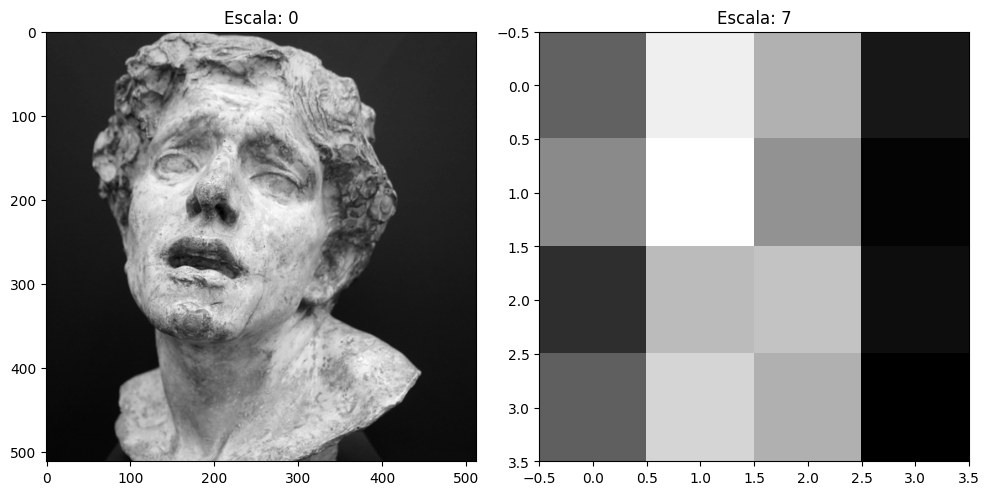

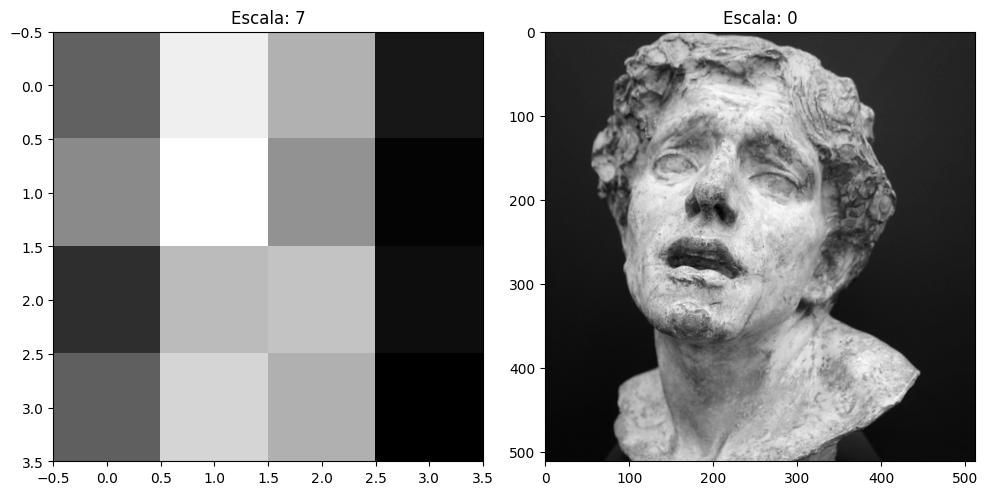

In [20]:
initial_time = time()
daubechies_4 = function_daubechies_coeffs(array_photo)
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,scale,width)
final_time = time()

print(f"The CPU time was {final_time - initial_time} seconds")


fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(array_photo, cmap='gray')
axes[0].set_title('Escala: 0')
axes[1].imshow(get_approx(normalized,scale), cmap='gray')
axes[1].set_title(f'Escala: {scale}')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(get_approx(normalized,scale), cmap='gray')
axes[0].set_title(f'Escala: {scale}')
axes[1].imshow(reconstructed, cmap='gray')
axes[1].set_title('Escala: 0')
plt.tight_layout()
plt.show()